In [1]:
# Base
import pandas as pd
import numpy as np
import json
import random as rnd
from math import floor
import pickle
from Myfunctions import *
from ast import literal_eval
import scipy
from scipy.stats import beta
from scipy import sparse
import random

#Preprocessing
from wordcloud import WordCloud

# Geo 
from geopy.geocoders import Nominatim
import gpxpy as gpx
import gpxpy.gpx

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from scipy.stats import norm
%matplotlib inline

# Data Engineering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,RobustScaler,StandardScaler,MinMaxScaler
from sklearn.externals import joblib
import datetime

# Debug
import sys
import pixiedust

# machine learning classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.metrics import log_loss

# machine learning regression
from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,BayesianRidge,LassoLarsIC
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

#Model Validation
from sklearn.metrics import confusion_matrix,precision_recall_curve,roc_curve,auc,roc_auc_score,f1_score,make_scorer
from sklearn.metrics import classification_report
from sklearn import datasets
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_classif,f_regression
from sklearn.pipeline import make_pipeline
from sklearn.utils.fixes import signature

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


Pixiedust database opened successfully


In [2]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key="AI...") # Your Google API key

# load a Numpy array of (latitude, longitude) pairs
locations = gmaps.datasets.load_dataset("taxi_rides")

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))
fig

Figure(layout=FigureLayout(height='420px'))

In [3]:
train_df = pd.read_json(r"C:\Users\kuangj\Desktop\Python\Rental\input\train.json",orient='columns',typ='frame')
test_df = pd.read_json(r"C:\Users\kuangj\Desktop\Python\Rental\input\test.json",orient='columns',typ='frame')

cols = list(train_df)
cols.insert(0, cols.pop(cols.index('listing_id')))
train_df = train_df.ix[:, cols]

cols = list(train_df)
cols.insert(1, cols.pop(cols.index('interest_level')))
train_df = train_df.ix[:, cols]

cols = list(test_df)
cols.insert(0, cols.pop(cols.index('listing_id')))
test_df = test_df.ix[:, cols]

train_df=train_df.rename(columns = {'interest_level':'TARGET'})
test_df=test_df.rename(columns = {'interest_level':'TARGET'})

In [4]:
target='TARGET'
train_cdf=train_df.drop(columns=target).copy(deep=True)
combinetry = train_cdf.append(test_df)
combinetry.shape

(124011, 14)

In [5]:
# train_df[target]=train_df[target].replace(['low','medium','high'],[0,1,2])

In [6]:
print(train_df.shape)
print(test_df.shape)
print(combinetry.shape)
test_df.head(3)

(49352, 15)
(74659, 14)
(124011, 14)


,listing_id,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,longitude,manager_id,photos,price,street_address
0,7142618,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,7210040,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,7103890,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street


In [7]:
# # train_df.to_csv('checktrain.csv',index=True)
# # test_df.drop(columns=['photos','features']).to_csv('test_df.csv',index=True)

# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('Data.xlsx', engine='xlsxwriter')
# # Convert the dataframe to an XlsxWriter Excel object.
# train_df.to_excel(writer, sheet_name='Train')
# test_df.to_excel(writer, sheet_name='Test')
# combinetry.to_excel(writer, sheet_name='Combine')
# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

# Data Engineering

In [8]:
bld_train_list = train_df.building_id.unique()
bld_test_list = test_df.building_id.unique()
bld_comb_list = combinetry.building_id.unique()
print("Train : {0}".format(len(bld_train_list)))
print("Test  : {0}".format(len(bld_test_list)))
print("Comb  : {0}".format(len(bld_comb_list)))
print("\nAverage entries for building in Train : {0: 1.3f}".format(len(train_df)/len(bld_train_list)))
print("Average entries for building in Test  : {0: 1.3f}".format(len(test_df)/len(bld_test_list)))
print("Average entries for building in Test  : {0: 1.3f}".format(len(combinetry)/len(bld_comb_list)))

Train : 7585
Test  : 9321
Comb  : 11635

Average entries for building in Train :  6.507
Average entries for building in Test  :  8.010
Average entries for building in Test  :  10.658


In [9]:
bld_not_in_test = set(bld_train_list) - set(bld_test_list)
bld_not_in_train = set(bld_test_list) - set(bld_train_list)

print("{} Building are featured in train.json but not in test.json".format(len(bld_not_in_test)))
print("{} Building are featured in test.json but not in train.json".format(len(bld_not_in_train)))

2314 Building are featured in train.json but not in test.json
4050 Building are featured in test.json but not in train.json


In [10]:
# num of Photos
train_df["num_photos"] = train_df["photos"].apply(len)
combinetry["num_photos"] = combinetry["photos"].apply(len)

# num of features
train_df["num_features"] = train_df["features"].apply(len)
combinetry["num_features"] = combinetry["features"].apply(len)

# num of words
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
combinetry["num_description_words"] = combinetry["description"].apply(lambda x: len(x.split(" ")))

# Created dates
train_df["created"] = pd.to_datetime(train_df["created"]).dt.date
train_df["create_period"]=((datetime.date.today()-train_df["created"]).dt.days/365).round(decimals=2)
combinetry["created"] = pd.to_datetime(combinetry["created"]).dt.date
combinetry["create_period"]=((datetime.date.today()-combinetry["created"]).dt.days/365).round(decimals=2)

# Building Feature

In [11]:
# Random training set
numset=5
index=list(range(train_df.shape[0]))
random.seed(46)
random.shuffle(index)

In [12]:
# Empirical Bayes on Training Set
train_mix=pd.DataFrame()
for i in range(numset):
    test_index = index[int((i*train_df.shape[0])/numset):int(((i+1)*train_df.shape[0])/numset)]
    train_index = list(set(index).difference(test_index))
    
    train_temp=train_df.iloc[train_index]
    test_temp=train_df.iloc[test_index]
    
    count_trans=train_temp.groupby(['manager_id','TARGET'])[['TARGET']].agg(['count'])
    count_trans = count_trans.unstack('TARGET')
    count_trans.columns = ['_'.join(col) for col in count_trans.columns.values]
    count_trans.rename(columns={'TARGET_count_high':'manager_high','TARGET_count_medium':'manager_med',
                           'TARGET_count_low':'manager_low'},inplace=True)
    cols = list(count_trans)
    cols.insert(1, cols.pop(cols.index('manager_med')))
    count_trans = count_trans.ix[:, cols]
    count_trans['manager_total']=count_trans.sum(axis=1)
    count_trans['manager_high_frac']=count_trans.manager_high/count_trans.manager_total
    count_trans['manager_med_frac']=count_trans.manager_med/count_trans.manager_total
    count_trans['manager_low_frac']=count_trans.manager_low/count_trans.manager_total
    count_trans['manager_id']=count_trans.index
    
    test_temp=test_temp.merge(count_trans.drop(columns=['manager_high','manager_med','manager_low',
                                      'manager_total']),how='left',on='manager_id')
    train_mix= train_mix.append(test_temp)

In [13]:
# Empirical Bayes on Test Set
test_sct=combinetry[train_df.shape[0]:].copy(deep=True)

count_trans=train_df.groupby(['manager_id','TARGET'])[['TARGET']].agg(['count'])
count_trans = count_trans.unstack('TARGET')
count_trans.columns = ['_'.join(col) for col in count_trans.columns.values]
count_trans.rename(columns={'TARGET_count_high':'manager_high','TARGET_count_medium':'manager_med',
                           'TARGET_count_low':'manager_low'},inplace=True)
cols = list(count_trans)
cols.insert(1, cols.pop(cols.index('manager_med')))
count_trans = count_trans.ix[:, cols]
count_trans['manager_total']=count_trans.sum(axis=1)
count_trans['manager_high_frac']=count_trans.manager_high/count_trans.manager_total
count_trans['manager_med_frac']=count_trans.manager_med/count_trans.manager_total
count_trans['manager_low_frac']=count_trans.manager_low/count_trans.manager_total
count_trans['manager_id']=count_trans.index
    
test_sc=test_sct.merge(count_trans.drop(columns=['manager_high','manager_med','manager_low',
                                      'manager_total']),how='left',on='manager_id')

In [14]:
# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('Beta_test.xlsx', engine='xlsxwriter')
# # Convert the dataframe to an XlsxWriter Excel object.
# train_mix.to_excel(writer, sheet_name='Train')
# test_sc.to_excel(writer, sheet_name='Test')
# writer.save()

In [15]:
train_df=train_mix.copy(deep=True)
tryme=train_df.copy(deep=True)

In [16]:
combine=train_df.drop(columns=['TARGET']).append(test_sc)
combineme=combine.copy(deep=True)

# New Feature

In [17]:
# Feature-----------------------

In [18]:
train_feat = tryme[['listing_id','features']].apply(lambda x: pd.Series(x['features']),axis=1).stack().reset_index(level=1, drop=True)
train_feat.name = 'feat'
train_feat=tryme[['listing_id','TARGET']].join(train_feat)

comb_feat = combineme[['listing_id','features']].apply(lambda x: pd.Series(x['features']),axis=1).stack().reset_index(level=1, drop=True)
comb_feat.name = 'feat'
comb_feat=combineme[['listing_id']].join(comb_feat)

In [19]:
col='feat'
print(train_feat[col].name,'*Num Unique*',train_feat[col].nunique(),train_feat[col].unique(),"\n")

feat *Num Unique* 1556 ['Cats Allowed' 'Fireplace' 'Dining Room' ... 'Eat-in-Kitchen'
 'S/S Appliances' '1 month free rent'] 



In [20]:
train_feat['TARGET'].value_counts()

low       925899
medium    311293
high      102311
Name: TARGET, dtype: int64

In [21]:
train_feat['feat'].isna().sum()

0

In [22]:
numfeat=50
kc=pd.crosstab(train_feat.feat,train_feat.TARGET).sort_values(by=['high'],ascending=False)
kc['hratio']=kc.high/(kc.high+kc.low+kc.medium)
kc['lratio']=kc.low/(kc.high+kc.low+kc.medium)
kc['l-hratio']=kc.lratio-kc.hratio
listfeat=kc.head(numfeat).index.tolist()
print(listfeat)
kc.head(numfeat)

['Elevator', 'Hardwood Floors', 'Cats Allowed', 'Dogs Allowed', 'Dishwasher', 'Doorman', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Laundry In Building', 'Balcony', 'Swimming Pool', 'New Construction', 'Exclusive', 'Terrace', 'Loft', 'Garden/Patio', 'Common Outdoor Space', 'Wheelchair Access', 'Reduced Fee', 'Furnished', 'Fireplace', 'SIMPLEX', 'HARDWOOD', 'prewar', 'Laundry In Unit', 'LOWRISE', 'Multi-Level', 'Garage', 'Laundry Room', 'Private Outdoor Space', 'Parking Space', 'Prewar', 'High Ceilings', 'PublicOutdoor', 'Renovated', 'Roof-deck', 'dishwasher', 'elevator', 'Green Building', 'Pool', 'HIGH CEILINGS', 'LAUNDRY', 'Stainless Steel Appliances']


TARGET,high,low,medium,hratio,lratio,l-hratio
feat,,,,,,
Elevator,9759,89981,29829,0.075319,0.694464,0.619145
Hardwood Floors,9305,80055,28275,0.079101,0.680537,0.601437
Cats Allowed,8919,82541,26234,0.075781,0.701319,0.625537
Dogs Allowed,8311,77338,24520,0.075439,0.701994,0.626556
Dishwasher,7815,69895,24420,0.076520,0.684373,0.607853
Doorman,7592,73251,23644,0.072660,0.701054,0.628394
No Fee,7237,61264,21809,0.080135,0.678374,0.598239
Laundry in Building,6159,56024,19537,0.075367,0.685560,0.610193
Fitness Center,4828,46244,15185,0.072868,0.697949,0.625081


In [23]:
train_feat.loc[~train_feat['feat'].isin(listfeat), 'feat'] = "Others"
comb_feat.loc[~comb_feat['feat'].isin(listfeat), 'feat'] = "Others"

In [24]:
pd.crosstab(train_feat.feat,train_feat.TARGET).sort_values(by=['high'],ascending=False)

TARGET,high,low,medium
feat,,,
Elevator,9759,89981,29829
Hardwood Floors,9305,80055,28275
Cats Allowed,8919,82541,26234
Dogs Allowed,8311,77338,24520
Dishwasher,7815,69895,24420
Doorman,7592,73251,23644
No Fee,7237,61264,21809
Laundry in Building,6159,56024,19537
Fitness Center,4828,46244,15185


In [25]:
kc.to_csv('checkflist.csv',index=True)

In [26]:
# cols = list(newtry)
# cols.insert(2, cols.pop(cols.index('feat')))
# newtry = newtry.ix[:, cols]
# combine = combine.ix[:, cols]

In [27]:
categorical = pd.get_dummies(train_feat['feat'])
categorical2 = pd.get_dummies(comb_feat['feat'])
categorical.head(10)

,Balcony,Cats Allowed,Common Outdoor Space,Dining Room,Dishwasher,Dogs Allowed,Doorman,Elevator,Exclusive,Fireplace,...,Roof Deck,Roof-deck,SIMPLEX,Stainless Steel Appliances,Swimming Pool,Terrace,Wheelchair Access,dishwasher,elevator,prewar
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# categorical = pd.get_dummies(newtry['feat'])
categorical['listing_id'] = train_feat['listing_id']
# categorical_grouped = categorical.groupby('listing_id').agg(['sum', 'mean'])
categorical_grouped = categorical.groupby('listing_id').agg(['sum'])

categorical2['listing_id'] = comb_feat['listing_id']
# categorical2_grouped = categorical2.groupby('listing_id').agg(['sum', 'mean'])
categorical2_grouped = categorical2.groupby('listing_id').agg(['sum'])

categorical_grouped.head()

,Balcony,Cats Allowed,Common Outdoor Space,Dining Room,Dishwasher,Dogs Allowed,Doorman,Elevator,Exclusive,Fireplace,...,Roof Deck,Roof-deck,SIMPLEX,Stainless Steel Appliances,Swimming Pool,Terrace,Wheelchair Access,dishwasher,elevator,prewar
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,...,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
listing_id,,,,,,,,,,,,,,,,,,,,,
6811957,0,2,0,0,0,2,2,2,0,0,...,0,0,1,0,0,0,0,0,0,1
6811965,0,4,0,0,2,4,1,2,0,0,...,0,0,0,0,1,0,0,0,0,0
6811966,1,3,1,0,1,3,3,3,0,0,...,0,0,0,0,0,1,0,0,0,0
6811973,0,2,1,2,2,2,4,4,0,0,...,3,0,0,0,2,0,1,0,0,0
6811975,1,3,0,0,1,3,2,5,1,0,...,1,0,0,0,1,0,1,1,0,0


In [29]:
group_var = 'listing_id'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        # for stat in ['count', 'count_norm']:
        for stat in ['count']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns
categorical_grouped['listing_id']=categorical_grouped.index.copy(deep=True)

In [30]:
group_var = 'listing_id'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical2_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        # for stat in ['count', 'count_norm']:
        for stat in ['count']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical2_grouped.columns = columns
categorical2_grouped['listing_id']=categorical2_grouped.index.copy(deep=True)

In [31]:
categorical_grouped.head()

,Balcony_count,Cats Allowed_count,Common Outdoor Space_count,Dining Room_count,Dishwasher_count,Dogs Allowed_count,Doorman_count,Elevator_count,Exclusive_count,Fireplace_count,...,Roof-deck_count,SIMPLEX_count,Stainless Steel Appliances_count,Swimming Pool_count,Terrace_count,Wheelchair Access_count,dishwasher_count,elevator_count,prewar_count,listing_id
listing_id,,,,,,,,,,,,,,,,,,,,,
6811957,0,2,0,0,0,2,2,2,0,0,...,0,1,0,0,0,0,0,0,1,6811957
6811965,0,4,0,0,2,4,1,2,0,0,...,0,0,0,1,0,0,0,0,0,6811965
6811966,1,3,1,0,1,3,3,3,0,0,...,0,0,0,0,1,0,0,0,0,6811966
6811973,0,2,1,2,2,2,4,4,0,0,...,0,0,0,2,0,1,0,0,0,6811973
6811975,1,3,0,0,1,3,2,5,1,0,...,0,0,0,1,0,1,1,0,0,6811975


In [32]:
newtrain = tryme.merge(categorical_grouped, on ='listing_id', how = 'left',validate='1:1')
combine = combineme.merge(categorical2_grouped, on ='listing_id', how = 'left',validate='1:1')

In [33]:
newtrain=newtrain.drop(columns=['photos','features'])
combine=combine.drop(columns=['photos','features'])

In [34]:
combine.head(4)

,listing_id,bathrooms,bedrooms,building_id,created,description,display_address,latitude,longitude,manager_id,...,Roof Deck_count,Roof-deck_count,SIMPLEX_count,Stainless Steel Appliances_count,Swimming Pool_count,Terrace_count,Wheelchair Access_count,dishwasher_count,elevator_count,prewar_count
0,7157664,1.0,3,4b70afd5fbfe6e5472b32abb03b22e8d,2016-06-14,"This is a fantastic, rare conv. 3 bed in a pri...",13th & First Ave.,40.7295,-73.9836,10b1ae0a38d50b7ba0cee612d14af9eb,...,0,0,0,0,0,0,0,0,0,0
1,7144190,1.0,1,47ba5ed8070ba4208c2edd51ecd9678e,2016-06-11,LOOK NO FURTHER!!\r\rNo Broker Fee!!\r\rDon't ...,williamsburg - NO FEE,40.7183,-73.9501,699c325b818541f314b691b76f3238d7,...,1,0,1,0,0,1,0,0,0,1
2,7174643,1.0,1,0,2016-06-17,Huge loft style one-bedroom apartment now avai...,Schermerhorn Street,40.6886,-73.9848,2504fa7eba54ebb09325c693bb283afc,...,3,0,0,0,0,0,0,0,0,0
3,6918838,1.0,2,cb0ecd5356125b546833239efdb154c2,2016-04-24,Modern Lobby with 24 hour conciergeValet Servi...,Gold St.,40.6969,-73.9830,5d50feb81c89a0e4bc3cb04fa88e9964,...,2,0,0,0,1,0,2,0,0,0


In [35]:
misstable,droplistfull=showmiss(newtrain)
droplistfull

,Total,Miss,Percent,Datatype
manager_high_frac,49352,19791,0.401017,float64
manager_med_frac,49352,9729,0.197135,float64
manager_low_frac,49352,1885,0.038195,float64


In [36]:
misstable,droplistfull=showmiss(combine)
droplistfull

,Total,Miss,Percent,Datatype
manager_high_frac,124011,48000,0.387062,float64
manager_med_frac,124011,23116,0.186403,float64
manager_low_frac,124011,4417,0.035618,float64


In [37]:
# newtrain.dtypes

In [38]:
newtrain=newtrain.drop(columns=['building_id','created','description','display_address','manager_id','street_address'])
combine=combine.drop(columns=['building_id','created','description','display_address','manager_id','street_address'])


In [39]:
newtrain['TARGET']=newtrain['TARGET'].replace(['low','medium','high'],[0,1,2])
yTarget=newtrain['TARGET']
newtrain['price']=np.log(newtrain['price'])
combine['price']=np.log(combine['price'])

In [40]:
newtrain.head(3)

,listing_id,TARGET,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,...,Roof Deck_count,Roof-deck_count,SIMPLEX_count,Stainless Steel Appliances_count,Swimming Pool_count,Terrace_count,Wheelchair Access_count,dishwasher_count,elevator_count,prewar_count
0,7157664,2,1.0,3,40.7295,-73.9836,8.146130,8,1,36,...,0,0,0,0,0,0,0,0,0,0
1,7144190,1,1.0,1,40.7183,-73.9501,7.919356,4,2,70,...,1,0,1,0,0,1,0,0,0,1
2,7174643,0,1.0,1,40.6886,-73.9848,8.004700,8,1,65,...,3,0,0,0,0,0,0,0,0,0


C:\Users\kuangj\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


The correlation between bedrooms and the TARGET is 0.0273
Median value for Target 0 = 1.0000
Median value for Target 1 = 2.0000
Median value for Target 2 = 2.0000


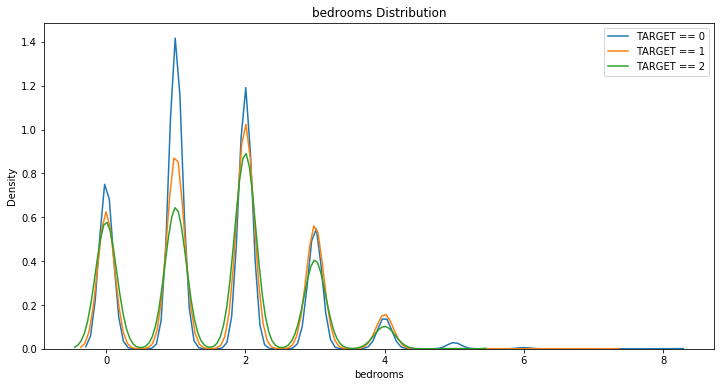

In [41]:
kde_target3(df=newtrain,var_name='bedrooms',targetvar='TARGET')

In [42]:
corrmat = newtrain.corr().sort_values(by=['TARGET'],ascending=False)

In [43]:
corrnum=5
coltop=corrmat['TARGET'][0:10]
colbot=corrmat['TARGET'][-10:]
colist=coltop.append(colbot)

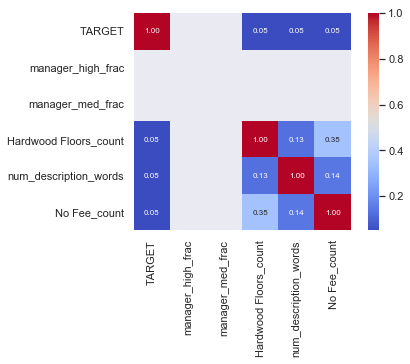

In [44]:
# Target correlation matrix
#number of variables for heatmap
k = 5 
cols = corrmat.nlargest(k+1, 'TARGET')['TARGET'].index
cmd = np.corrcoef(newtrain[cols].values.T)
fig = plt.figure()
sns.set(font_scale=1)
hm = sns.heatmap(cmd,cmap="coolwarm",cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8},yticklabels=cols.values, xticklabels=cols.values)
plt.show()

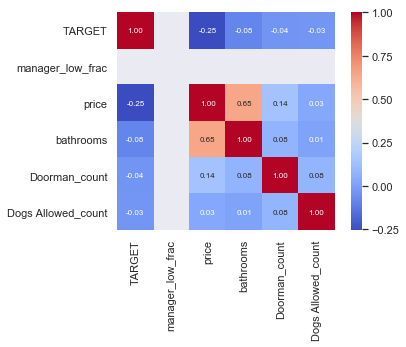

In [45]:
# Target correlation matrix
#number of variables for heatmap
k = 5 
cols = corrmat.nsmallest(k, 'TARGET')['TARGET'].index
cols=cols.insert(0,'TARGET')
cmd = np.corrcoef(newtrain[cols].values.T)
fig = plt.figure()
sns.set(font_scale=1)
hm = sns.heatmap(cmd,cmap="coolwarm",cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8},yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [46]:
# le = LabelEncoder()
# le.fit(newtrain['interest_level'])
# newtrain['interest_level'] = le.transform(newtrain['interest_level'])
# newtrain['interest_level']

In [47]:
newtrain.head(10)

,listing_id,TARGET,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,...,Roof Deck_count,Roof-deck_count,SIMPLEX_count,Stainless Steel Appliances_count,Swimming Pool_count,Terrace_count,Wheelchair Access_count,dishwasher_count,elevator_count,prewar_count
0,7157664,2,1.0,3,40.7295,-73.9836,8.146130,8,1,36,...,0,0,0,0,0,0,0,0,0,0
1,7144190,1,1.0,1,40.7183,-73.9501,7.919356,4,2,70,...,1,0,1,0,0,1,0,0,0,1
2,7174643,0,1.0,1,40.6886,-73.9848,8.004700,8,1,65,...,3,0,0,0,0,0,0,0,0,0
3,6918838,2,1.0,2,40.6969,-73.9830,7.930206,9,15,69,...,1,0,0,0,1,0,1,0,0,0
4,6895741,0,1.0,1,40.7634,-73.9638,8.292799,3,4,76,...,0,0,0,0,0,0,0,0,0,0
5,7006582,0,2.0,1,40.7749,-73.9455,8.517193,12,5,71,...,1,0,0,0,1,0,0,0,0,0
6,7138924,0,2.0,2,40.7152,-74.0116,8.922658,5,10,206,...,0,0,0,0,0,1,0,0,0,0
7,7211575,0,2.0,3,40.7457,-74.0032,9.615472,5,3,128,...,4,0,0,0,0,0,0,0,0,0
8,6836232,0,2.0,2,40.7746,-73.9900,8.881836,4,5,132,...,2,0,0,0,1,1,0,0,0,0
9,7060022,1,1.0,2,40.7282,-73.9892,7.833996,3,2,128,...,0,0,0,0,0,0,0,0,0,0


In [48]:
col='street_address'
print(train_df[col].name,'*Num Unique*',train_df[col].nunique(),train_df[col].unique(),"\n")

street_address *Num Unique* 15358 ['200 First Avenue' '716 Lorimer Street ' '233 Schermerhorn Street' ...
 '416 E 71st St' '310 e 89' 'E 57th and 9th Ave'] 



In [49]:
# geolocator = Nominatim()
# location = geolocator.geocode("792 Metropolitan Avenue NYC",timeout=100)

In [50]:
# location = geolocator.reverse("40.7145, -73.9425",timeout=100)
# print(location.address)
# loc=location.raw
# loc
# # ploc=pd.DataFrame.from_dict(loc)

In [51]:
# # location = geolocator.reverse("40.727, -74.0308",timeout=100)
# location = geolocator.reverse("40.7348, -73.9817",timeout=100)
# print(location.address)
# loc=location.raw
# loc
# # ploc=pd.DataFrame.from_dict(loc)

# Feature Scaling

In [52]:
# cmohe=combine.drop(columns='ID').copy(deep=True)
cmohe=combine.copy(deep=True)

In [53]:
train_df.head(2)

,listing_id,TARGET,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,...,photos,price,street_address,num_photos,num_features,num_description_words,create_period,manager_high_frac,manager_med_frac,manager_low_frac
0,7157664,high,1.0,3,4b70afd5fbfe6e5472b32abb03b22e8d,2016-06-14,"This is a fantastic, rare conv. 3 bed in a pri...",13th & First Ave.,[Cats Allowed],40.7295,...,[https://photos.renthop.com/2/7157664_e851ac9a...,3450,200 First Avenue,8,1,36,2.61,0.111111,0.250,0.638889
1,7144190,medium,1.0,1,47ba5ed8070ba4208c2edd51ecd9678e,2016-06-11,LOOK NO FURTHER!!\r\rNo Broker Fee!!\r\rDon't ...,williamsburg - NO FEE,"[No Fee, ** NO FEE BKLN LUXURY! * EXPANSIVE 1B...",40.7183,...,[https://photos.renthop.com/2/7144190_8a8f8496...,2750,716 Lorimer Street,4,2,70,2.62,0.104000,0.304,0.592000


In [54]:
# feature scaling, for numerical data, use (x-min)/(max-min)
# train_sct=cmohe[0:train_df.shape[0]].copy(deep=True)
# test_sct=cmohe[train_df.shape[0]:].copy(deep=True)

train_sct=train_df[['listing_id']].merge(combine,on='listing_id',how='left')
test_sct=test_df[['listing_id']].merge(combine,on='listing_id',how='left')

# train_sc=train_sct.drop(columns=['listing_id','building_high','building_medium','building_low','building_score']).copy(deep=True)
# test_sc=test_sct.drop(columns=['listing_id','building_high','building_medium','building_low','building_score']).copy(deep=True)

train_sc=train_sct.copy(deep=True)
test_sc=test_sct.copy(deep=True)

# scaler = MinMaxScaler(feature_range = (0, 1))
# transformer = scaler.fit(train_sct)
# train_sc=transformer.transform(train_sct)
# train_sc = pd.DataFrame(train_sc, columns=train_sct.columns).drop(columns='listing_id')
# test_sc=transformer.transform(test_sct)
# test_sc = pd.DataFrame(test_sc, columns=test_sct.columns).drop(columns='listing_id')

# cms=train_sc.append(test_sc)
# cms.describe().to_csv('scalecheck.csv',index=True)
# test_sct.to_csv('test_sct.csv',index=True)

In [55]:
# # After Encoder

# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('Data_model.xlsx', engine='xlsxwriter')
# # Convert the dataframe to an XlsxWriter Excel object.
# train_sct.to_excel(writer, sheet_name='Train')
# test_sct.to_excel(writer, sheet_name='Test')
# combine.to_excel(writer, sheet_name='Combine')
# x2.to_excel(writer, sheet_name='x2')
# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

In [56]:
# Split Training Data into Sub_Train and Sub_Validation
xTrain, xTest, yTrain, yTest = train_test_split(train_sc, yTarget, test_size = 0.3, random_state = 46,stratify=yTarget)

# Modeling

# LightGBM

In [57]:
lgbmodel = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=3000, objective = 'multiclass',
                              class_weight = 'balanced', learning_rate = 0.1,
                              reg_alpha = 1, reg_lambda = 0, 
                              subsample = 0.7, n_jobs = -1,
                              random_state = 50,importance_type='gain',silent=False)

# lgbmodel = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=3000, objective = 'multiclass',
#                               class_weight = 'balanced', learning_rate = 0.05,
#                               reg_alpha = 1, reg_lambda = 1, 
#                               max_depth=50,min_data_in_leaf=10,
#                               subsample = 1, n_jobs = -1,
#                               random_state = 50,importance_type='gain',silent=False)

In [58]:
lgbm2=lgbmodel.fit(xTrain, yTrain, eval_metric = ['multi_logloss'],
                  eval_set = [(xTest, yTest), (xTrain, yTrain)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 200, verbose = 200)

Training until validation scores don't improve for 200 rounds.
[200]	train's multi_logloss: 0.541486	train's multi_logloss: 0.541486	valid's multi_logloss: 0.682592	valid's multi_logloss: 0.682592
[400]	train's multi_logloss: 0.403412	train's multi_logloss: 0.403412	valid's multi_logloss: 0.650448	valid's multi_logloss: 0.650448
[600]	train's multi_logloss: 0.313072	train's multi_logloss: 0.313072	valid's multi_logloss: 0.633102	valid's multi_logloss: 0.633102
[800]	train's multi_logloss: 0.249551	train's multi_logloss: 0.249551	valid's multi_logloss: 0.623143	valid's multi_logloss: 0.623143
[1000]	train's multi_logloss: 0.20284	train's multi_logloss: 0.20284	valid's multi_logloss: 0.618183	valid's multi_logloss: 0.618183
[1200]	train's multi_logloss: 0.16684	train's multi_logloss: 0.16684	valid's multi_logloss: 0.615651	valid's multi_logloss: 0.615651
[1400]	train's multi_logloss: 0.139324	train's multi_logloss: 0.139324	valid's multi_logloss: 0.615445	valid's multi_logloss: 0.615445


In [59]:
lgb2_pred = lgbm2.predict(xTest)
lgb2_prob = lgbm2.predict_proba(xTest)

In [60]:
matrix_log=confusion_matrix(yTest,lgb2_pred,labels=[2,1,0])

In [61]:
print(classification_report(yTest, lgb2_pred))
# precision, recall, thresholds = precision_recall_curve(y_true=yTest['TARGET'], probas_pred=lgb2_prob, pos_label=1)
# print('Max F1',max((2*precision*recall)/(precision+recall)))
# plot_prec_recall_vs_tresh(precision, recall, thresholds)
# plt.show()

              precision    recall  f1-score   support

           0       0.87      0.82      0.84     10285
           1       0.45      0.54      0.49      3369
           2       0.45      0.38      0.41      1152

   micro avg       0.72      0.72      0.72     14806
   macro avg       0.59      0.58      0.58     14806
weighted avg       0.74      0.72      0.73     14806



In [62]:
#CV
lgbcv = lgb.LGBMClassifier()

In [63]:
# nr_cv=3
# score='neg_log_loss'
# parameters = {'boosting_type':['gbdt'],'n_estimators':[2000], 'objective':['multiclass'],'class_weight': ['balanced'],
#               'learning_rate':[0.01,0.1,1],
#               'reg_alpha':[0.01,0.1,1,10],
#               'reg_lambda':[0.01,0.1,1,10],'subsample':[1], 'n_jobs':[-1],
#               'random_state':[50],'importance_type':['gain']}
# nr_cv=3
# score='neg_log_loss'
# parameters = {'boosting_type':['gbdt'],'n_estimators':[3000], 'objective':['multiclass'],'class_weight': ['balanced'],
#               'learning_rate':[0.01,0.1,1],
#               'reg_alpha':[0,0.1,1,10,100],
#               'reg_lambda':[0,0.1,1,10,100],'subsample':[1], 'n_jobs':[-1],
#               'max_depth':[5,20,100],'min_data_in_leaf':[5,20,100],
#               'reg_lambda':[0,0.1,1,10,100],'subsample':[1], 'n_jobs':[-1],
#               'random_state':[50],'importance_type':['gain']}

# grid_lgb = GridSearchCV(lgbcv, parameters, cv=nr_cv, scoring = score,verbose=1)
# grid_lgb.fit(xTrain, yTrain)

In [64]:
# print('Best Score is:',grid_lgb.best_score_)
# print('Best Params is:',grid_lgb.best_params_)

NameError: name 'grid_lgb' is not defined

In [ ]:
# Learning Curves
# c=[0.1,0.5,1.0]
# cv=3
# model=lgbm2
# score='neg_log_loss'

# # train_sizes, train_scores, valid_scores = learning_curve(estimator=model, X=xTrain, y=yTrain, scoring=score,train_sizes=c, cv=cv)
# title = 'Learning Curves'
# plot_learning_curve(model, title,X=xTrain, y=yTrain,train_sizes=c,cv=cv,scoring=score,ylim=(0.0, -1.01))

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbm2.feature_importances_,xTrain.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

# Final Production

In [ ]:
# log_prob = logmodel.predict_proba(test_sc)[:, 1]
# rf_prob = rf.predict_proba(test_sc)[:, 1]
# NNclf_prob = NNclf.predict_proba(test_sc)[:,1]
# xgb_prob = xgbm2.predict_proba(test_sc)[:,1]
lgb_prob = lgbm2.predict_proba(test_sc)

# probtable=pd.DataFrame({'ID':test_sct['ID'],'Log':log_prob,'RF':rf_prob,'NN':NNclf_prob,'XGB':xgb_prob
#                        ,'LGB':lgb_prob})
# prob=(lgb_prob+xgb_prob+NNclf_prob+rf_prob+log_prob)/5
prob=lgb_prob
# probtable.head()

In [ ]:
temp=pd.DataFrame(prob,columns=['low','medium','high'])
# submit=pd.concat([test_df['listing_id'],temp], axis=1,ignore_index=True)
temp1=pd.DataFrame(test_df['listing_id'].values,columns=['listing_id'])
submit=pd.concat([temp1,temp],axis=1)
cols = list(submit)
cols.insert(1, cols.pop(cols.index('high')))
cols.insert(2, cols.pop(cols.index('medium')))
submit = submit.ix[:, cols]
submit.to_csv('submit_temp.csv',index=False)

In [ ]:
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
# clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
# GridSearchCV(cv=None,
#              estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
#                dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
#              param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [ ]:
# plt.figure()
# plot_confusion_matrix(matrix_log, classes=class_names,
#                       title='Confusion matrix, without normalization')